# Across Time

Here I will try to reproduce Miyawaki2016 / Torrado2021 analysis in which they show the average FR across sleep

In [1]:
from imports import *

In [178]:
def main_delta(base_folder,local_path,**kwargs):
    stru = kwargs['stru']
    types = kwargs['types']
    length_compute_fr = kwargs['length_compute_fr']
    time_from_border = kwargs['time_from_border']

    bk.load.current_session_linux(base_folder,local_path)
    
    neurons, metadata = bk.load.spikes()
    neurons = neurons[(metadata.Region == stru) & (metadata.Type == types)]

    states = bk.load.states(True)
    extended_sleep = bk.compute.extended(states)
    if len(extended_sleep) == 0: return None
    # else: return metadata
    deltas = {}
    for state in ['NREM','REM']:
        deltas[state] = []
        for s, e in extended_sleep.iloc:
            current_sleep = nts.IntervalSet(s, e)
            state_intervals = states[state].intersect(current_sleep)
            # state_intervals = state_intervals.drop_short_intervals(time_from_border[state]*2, 's').reset_index(drop=True)
            # bk.misc.discard_border(state_intervals,time_from_border[state])

            act = bk.compute.binSpikes(neurons,1,as_Tsd = True).restrict(state_intervals)

            # act = bk.compute.nts_zscore(act)
            act = nts.Tsd(act.times(),np.nanmean(act.values,1))
            fr_beg = np.nansum(act.iloc[0:length_compute_fr].values,0)/length_compute_fr
            fr_end = np.nansum(act.iloc[-length_compute_fr:-1].values,0)/length_compute_fr
            deltas[state].append(fr_end-fr_beg)
        
    df = pd.DataFrame({'delta_NREM':deltas['NREM'],
                       'delta_REM':deltas['REM']})
    return df


def across_time(base_folder, local_path, *args, **kwargs):

    binSize = kwargs['binSize']
    stru = kwargs['stru']
    types = kwargs['types']
    time_from_border = kwargs['time_from_border']
    min_duration = kwargs['min_duration']

    bk.load.current_session_linux(base_folder = base_folder, local_path=local_path)
    states = bk.load.states(True)
    neurons, metadata = bk.load.spikes()
    neurons = neurons[(metadata.Region == stru) & (metadata.Type == types)]

    z_fr_across_extended = {}

    extended_sleep = bk.compute.extended(states, 'sleep', 60*30, 60)

    for state in ['NREM', 'REM']:
        ext_sleep_b = []
        for s, e in extended_sleep.as_units('s').iloc:
            t, b = bk.compute.binSpikes(neurons, binSize, s, e)
            states[state] = states[state].drop_short_intervals(min_duration[state], 's').reset_index(drop=True)
            bk.misc.discard_border(states[state],time_from_border[state])
            
            b = nts.TsdFrame(t, b.T, 's').restrict(states[state])
            b.index = b.index- int(s*1_000_000)
            # b = bk.compute.nts_zscore(b)
            b = nts.Tsd(b.times().astype(int),np.nanmean(b.values,1))
            ext_sleep_b.append(b)

        z_fr_across_extended[state] = ext_sleep_b

    extended_wake = bk.compute.extended(states, 'wake', 60, 60*30) 
    ext_wake_b = []
    for s, e in extended_wake.as_units('s').iloc:
        states['WAKE_HOMECAGE'] = states['WAKE_HOMECAGE'].drop_short_intervals(min_duration['WAKE_HOMECAGE'], 's').reset_index(drop=True)
        t, b = bk.compute.binSpikes(neurons, binSize, s+time_from_border['WAKE_HOMECAGE'], e-time_from_border['WAKE_HOMECAGE'])
        b = nts.TsdFrame(t-s, b.T, 's')
        # b = bk.compute.nts_zscore(b)
        b = nts.Tsd(np.round(b.times()),np.nanmean(b.values,1))
        ext_wake_b.append(b)
    z_fr_across_extended['WAKE_HOMECAGE'] = ext_wake_b

    return z_fr_across_extended


def merge(batch):
    activiy = {'NREM':[],
               'REM':[],
               'WAKE_HOMECAGE':[]}
    for sess,b in batch.items():
        for state in b:
            for i in b[state]:
                activiy[state].append(i)
    return activiy


In [179]:
kwargs = {'stru': 'BLA',
          'types': 'Pyr',
          'length_compute_fr': 120,
          'time_from_border': {
              'REM': 5,
              'NREM': 20,
              'WAKE_HOMECAGE': 20
          }}
# z = main_delta('/mnt/electrophy/Gabrielle/GG-Dataset-Light/','Rat08/Rat08-20130708', **kwargs)

batch_delta, metadata_delta = bk.load.batch(main_delta, **kwargs)


100%|██████████| 61/61 [01:03<00:00,  1.04s/it]

['Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140405', 'Rat09-20140408', 'Rat09-20140409', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150315', 'Rat11-20150401']
Batch finished in 63.291491746902466
Some session were not processed correctly
['Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140405', 'Rat09-20140408', 'Rat09-20140409', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150315', 'Rat11-20150401']
19.672131147540984 %


In [180]:
binSize = 30
kwargs = {
    'binSize': binSize,
    'stru': 'BLA',
    'types': 'Pyr',
    'time_from_border': {
        'REM': 5,
        'NREM': 20,
        'WAKE_HOMECAGE': 20
    },
    'min_duration': {
        'REM': 50,
        'NREM': 250,
        'WAKE_HOMECAGE': 250
    }
}
# z = across_time('/mnt/electrophy/Gabrielle/GG-Dataset-Light/','Rat08/Rat08-20130708', **kwargs)
batch, metadata = bk.load.batch(across_time, **kwargs)

100%|██████████| 61/61 [01:01<00:00,  1.00s/it]

['Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140705', 'Rat10-20140707', 'Rat10-20140708', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150314', 'Rat11-20150315', 'Rat11-20150316', 'Rat11-20150317', 'Rat11-20150401', 'Rat11-20150402']
Batch finished in 61.04941248893738
Some session were not processed correctly
['Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140705', 'Rat10-20140707', 'Rat10-20140708', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150314', 'Rat11-20150315', 'Rat11-20150316', 'Rat11-20150317', 'Rat11-20150401', 'Rat11-20150402']
34.42622950819672 %


In [181]:
def average_by_bin(t,data,nbins):
    print(t[0]/1_000_000,t[-1]/1_000_000)
    bins = np.linspace(0,6000*1_000_000,nbins+1)
    digitized = np.digitize(t,bins)
    bin_means = [np.nanmean(data[digitized==i]) for i in range(1,len(bins))]
    bin_sem = [scipy.stats.sem(data[digitized==i].values.ravel(),nan_policy='omit') for i in range(1,len(bins))]

    t = np.convolve(bins,(0.5,0.5),'same')[:-1]
    return t,bin_means,bin_sem

## Plot

In [187]:
def plot(merged,state,color,ax):
    df = pd.concat(merged[state],1)
    df['Times'] = df.index.values
    df_melt = df.melt(id_vars='Times',value_name='FR')
    df_melt.dropna(inplace=True)
    df = df.drop('Times',axis = 1)
    reg = scipy.stats.linregress(df_melt.Times/1_000_000,df_melt.FR)
    print(reg)
    print(len(df_melt))      
    x = range(6000)
    y = x*reg.slope + reg.intercept
    
    if ax is None:
        fig,ax = plt.subplots(1,2)
    for i in df:
        sns.scatterplot(x = df.index/1_000_000,y = df[i],color = color,ax=ax[0],alpha = 0.8,s = 10)
    ax[0].plot(x,y,'k--')
    ax[0].text(4000,1.2,f'r = {reg.rvalue:.3f} \np = {reg.pvalue:.4f}')
    # ax[0].set_ylim(-2,2)
    ax[0].set_xlim(-500,6000)
    bk.plot.forceAspect(ax[0])
    ax[0].set_xlabel('Time from start of ext. sleep (s)')
    ax[0].set_ylabel('Firing rates (Z)')
    
    t,average,sem = average_by_bin(df.index.values,df,10)
    
    # ax[1].errorbar(df.index/1_000_000,np.nanmean(df,1),scipy.stats.sem(df,1,nan_policy='omit'),linestyle='None',marker = '.',color = color)
    ax[1].errorbar(t/1_000_000,average,sem,linestyle='None',marker = '.',color = color,barsabove=True)

    
    
    
    ax[1]
    ax[1].plot(x,y,'k--')
    # ax[1].set_ylim(-0.5,0.5)
    ax[1].set_xlim(-500,6000)
    bk.plot.forceAspect(ax[1])


/tmp/ipykernel_2711009/2585506687.py:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df = pd.concat(merged[state],1)


LinregressResult(slope=-0.0007339883439664718, intercept=22.431237412449534, rvalue=-0.10156325471022389, pvalue=1.1408335740351883e-05, stderr=0.00016679313502300177, intercept_stderr=0.2679906044415728)
1860
435.0 5415.0
LinregressResult(slope=0.0005948750662098693, intercept=22.822171355796478, rvalue=0.06327353557571294, pvalue=0.20666967272068854, stderr=0.00047031737687587165, intercept_stderr=0.8933756258113812)
400


/home/billel/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:3379: UserWarning: Warning: converting a masked element to nan.
  _data[indx] = dval
/tmp/ipykernel_2711009/2585506687.py:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df = pd.concat(merged[state],1)


255.0 1635.0


/tmp/ipykernel_2711009/3771695195.py:5: RuntimeWarning: Mean of empty slice
  bin_means = [np.nanmean(data[digitized==i]) for i in range(1,len(bins))]
/home/billel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/billel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/billel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


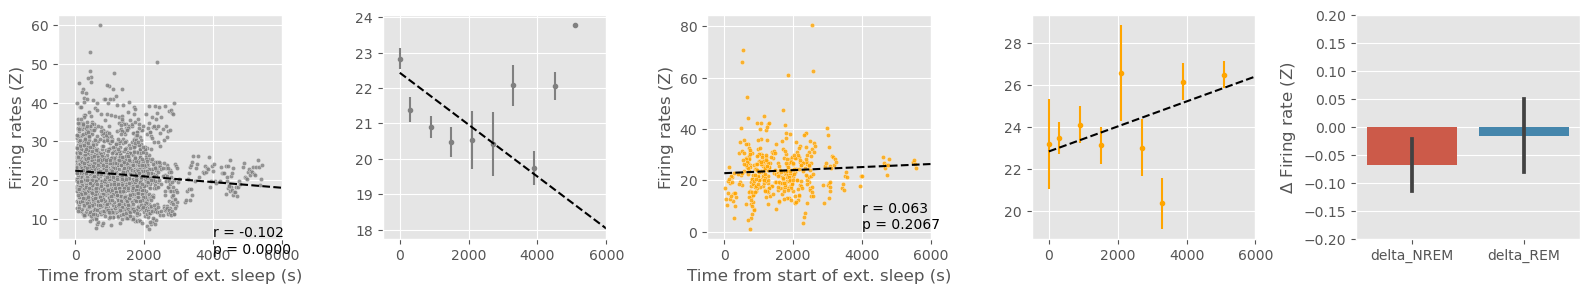

In [188]:
df = pd.concat(batch_delta)
merged = merge(batch)
fig, ax = plt.subplots(1, 5,figsize = (16,8))
plot(merged, 'NREM', 'grey', ax=ax[0:2])
plot(merged, 'REM', 'orange', ax=ax[2:4])
sns.barplot(df,ax = ax[4])
plt.ylim(-0.2,.2)
ax[4].set_ylabel('$\Delta$ Firing rate (Z)')
bk.plot.forceAspect(ax[4],1)
plt.tight_layout()
# plt.savefig('/home/billel/pCloudDrive/IFM/work/Figures/ByFindings/BLA_Decrease_FR_ES/decrease2.svg')

In [177]:
len(df)

35

In [175]:
print(scipy.stats.shapiro(df['delta_NREM']))
print(scipy.stats.ttest_1samp(df['delta_NREM'],0))

ShapiroResult(statistic=0.9788095355033875, pvalue=0.7200368642807007)
Ttest_1sampResult(statistic=-2.6919456954930867, pvalue=0.010941926322522489)


In [176]:
print(scipy.stats.shapiro(df['delta_REM']))
print(scipy.stats.ttest_1samp(df['delta_REM'],0))

ShapiroResult(statistic=0.9826956391334534, pvalue=0.8427566289901733)
Ttest_1sampResult(statistic=-0.8471610509926805, pvalue=0.40282938348800446)
